In [1]:
pip install sns

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\eser.arslan\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.neighbors import KNeighborsClassifier

In [3]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Load Train dataset
train = pd.read_csv("train.csv")
train.head(2).append(train.tail(2))

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
train.shape

In [ ]:
train.dtypes

In [ ]:
train.revenue_category.unique()

In [ ]:
# Replace Numpy Nan values with 0 and 'nan'
for col in train.columns:
  if train[col].dtypes == object:
    train[col].fillna(value='nan', inplace=True)
  else:
    train[col].fillna(value=0, inplace=True)

In [ ]:
train.country = train.country.replace(" ", "", regex=True)
train.genres = train.genres.replace(" ", "", regex=True)
train.language = train.language.replace(" ", "", regex=True)

In [ ]:
train = pd.concat([train.drop('country', axis=1), train.country.str.get_dummies(sep=',').add_prefix('country_')], axis=1)
train = pd.concat([train.drop('language', axis=1), train.language.str.get_dummies(sep=',').add_prefix('language_')], axis=1)
train = pd.concat([train.drop('genres', axis=1), train.genres.str.get_dummies(sep=',').add_prefix('genres_')], axis=1)



In [ ]:
train.head(2).append(train.tail(2))

In [ ]:
train[train.writer_count == 3.0].iloc[0]

In [ ]:
train.genres_Comedy.head()

In [ ]:
train.head()

In [ ]:
train.censor_rating.unique()

In [ ]:
censor_rating_mapping = {
    'G' : 20,
    'Not Rated' : 0,
    'R' : 45,
    'PG-13' : 35, 
    'PG' : 30, 
    'NOT RATED' : 0, 
    'Unrated' : 0,
    'UNRATED' : 0,
    'nan' : 0
}

In [ ]:
train['censor_rating'] = train.censor_rating.replace(censor_rating_mapping)
train.head()

In [ ]:
train.runtime = train.runtime.replace(' min', '', regex = True)
train.head()

In [ ]:
train.ratings_imdb = train.ratings_imdb.replace('/10', '', regex=True)
train.ratings_imdb = train.ratings_imdb.astype(float) * 10
train.head()

In [ ]:
train.ratings_metacritic = train.ratings_metacritic.replace('/100', '', regex=True)
train.ratings_tomatoes = train.ratings_tomatoes.replace('%', '', regex=True)
train.head()

In [ ]:
train['release_day'] = train.release_date.str.split('-', expand=True)[0]
train['release_month'] = train.release_date.str.split('-', expand=True)[1]
train['release_year'] = train.release_date.str.split('-', expand=True)[2]

In [ ]:
train['release_year'] = pd.to_numeric(train['release_year'], errors='coerce')

In [ ]:
train['release_year'] = train['release_year'].astype(float)
train['release_year'] = train['release_year'] + 2000

In [ ]:
train['dvd_release_day'] = train.dvd_release_date.str.split('-', expand=True)[0]
train['dvd_release_month'] = train.dvd_release_date.str.split('-', expand=True)[1]
train['dvd_release_year'] = train.dvd_release_date.str.split('-', expand=True)[2]

In [ ]:
train['dvd_release_year'] = train['dvd_release_year'].astype(float)
train['dvd_release_year'] = train['dvd_release_year'] + 2000

In [ ]:
drop_date_column = ['release_date', 'dvd_release_date']
train = train.drop(columns = drop_date_column)
train.head(2)

In [ ]:
month_mapping = {"May" : 5,
                 "Jul" : 7,
                 "Feb" : 2,
                 "Jun" : 6,
                 "Aug" : 8,
                 "Jan" : 1,
                 "Oct" : 10,
                 "Dec" : 12,
                 "Nov" : 11,
                 "None" : 20,
                 "Mar" : 3,
                 "Apr" : 4,
                 "Sep" : 9
}

In [ ]:
train['release_month'] = train.release_month.replace(month_mapping)
train['dvd_release_month'] = train.dvd_release_month.replace(month_mapping)
train.head()

In [ ]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

In [ ]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
  all_bins = []
  
  for method in bins_methods:
    start = datetime.now()
    hist, bin_edges = np.histogram(column_name,bins=method)
    all_bins.append(bin_edges)
    print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
  return all_bins

In [ ]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)

In [ ]:
#Cartamount Bins
def call_bin(col):
  all_bins = []
  all_bins = get_columns_bins(train[col])

  col_bin,label = get_clustering_bins(pd.Series(all_bins[0]), quantile=0.2, n_samples=10)
  train[col].hist(bins=col_bin)

  col_bin

  train[col].value_counts().head()

  train[col] = pd.cut(train[col], col_bin).cat.codes

  len(col_bin) , train[col].value_counts(bins=col_bin)

In [ ]:
bin_cols = ['censor_rating', 'runtime', 'users_votes', 'comments', 'likes', 'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes', 'ratings_metacritic', 'awards_win', 'awards_nomination']

In [ ]:
for col in bin_cols:
  print("{} columns started to bin process" .format(col))
  train[col] = pd.to_numeric(train[col], errors='coerce')
  train[col].fillna(value=0, inplace=True)
  call_bin(col)

In [ ]:
train.shape

In [ ]:
train.revenue_category.unique()

In [ ]:
revenue_category_mapping = {
    "High" : 1,
    "Low" : 0
}

In [ ]:
train['predict_rev_cat'] = train.revenue_category.replace(revenue_category_mapping)
train.head()

In [ ]:
train.drop(columns='revenue_category')

In [ ]:
quantative_columns = ['writer_count', 'censor_rating', 'runtime', 'users_votes', 'comments', 'likes', 'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes', 'ratings_metacritic', 'special_award', 'awards_win', 'awards_nomination', 'predict_rev_cat']
train2 = train[quantative_columns]

In [ ]:
train2.head()

In [ ]:
train2.shape

In [ ]:
#Calculate correlations
corr = train2.corr()
corr

In [ ]:
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'predict_rev_cat'][:50]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.2].sort_values(ascending=False)
len(best_accurate_columns)

In [ ]:
best_accurate_columns.keys()

In [ ]:
quantative_columns

In [ ]:
drop_cols = ['runtime',
 'users_votes',
 'comments',
 'likes',
 'overall_views',
 'dislikes',
 'ratings_imdb',
 'ratings_metacritic',
 'awards_win']

In [ ]:
train_df = train.copy()

In [ ]:
train_df = train_df.drop(columns=drop_cols)

In [ ]:
train_df.shape

In [ ]:
for col in best_accurate_columns.keys():
    if col in train_df:
      if col != 'predict_rev_cat':
        train_df["{}_2".format(col)] = train_df[col]
        train_df["{}_3".format(col)] = train_df[col]

In [ ]:
train_df.shape

In [ ]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
train_df.head()

In [ ]:
cols = train_df.columns.tolist()

In [ ]:
cols[251:252]

In [ ]:
cols = cols[:251] + cols[252:] + cols[251:252]

In [ ]:
train_df = train_df[cols]
train_df.head()

In [ ]:
dc = ['title', 'revenue_category']

In [ ]:
train_df = train_df.drop(columns=dc)

In [61]:
train_df.iloc[:,0:259]

,writer_count,title_adaption,censor_rating,ratings_tomatoes,special_award,awards_nomination,country_Afghanistan,country_Albania,country_Algeria,country_Argentina,country_Australia,country_Austria,country_Bahamas,country_Belarus,country_Belgium,country_Bolivia,country_BosniaandHerzegovina,country_Brazil,country_Bulgaria,country_Cambodia,country_Cameroon,country_Canada,country_CaymanIslands,country_Chad,country_Chile,country_China,country_Colombia,country_Croatia,country_CzechRepublic,country_Denmark,country_DominicanRepublic,country_Ecuador,country_Egypt,country_Ethiopia,country_Finland,country_France,country_Georgia,country_Germany,country_Ghana,country_Greece,country_Greenland,country_HongKong,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Iran,country_Ireland,country_IsleOfMan,country_Israel,country_Italy,country_Japan,country_Jordan,country_Kenya,country_Latvia,country_Lebanon,country_Lithuania,country_Luxembourg,country_Malaysia,country_Malta,country_Mauritania,country_Mexico,country_Monaco,country_Mongolia,country_Morocco,country_Namibia,country_Netherlands,country_NewZealand,country_Nigeria,country_Norway,country_Paraguay,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Qatar,country_Romania,country_Russia,country_SaudiArabia,country_Serbia,country_Singapore,country_Slovakia,country_Slovenia,country_SouthAfrica,country_SouthKorea,country_SovietUnion,country_Spain,country_Sweden,country_Switzerland,country_Taiwan,country_Tanzania,country_Thailand,country_TrinidadandTobago,country_Tunisia,country_Turkey,country_UK,country_USA,country_Uganda,country_Ukraine,country_UnitedArabEmirates,country_Uruguay,language_Aboriginal,language_Acholi,language_Afrikaans,language_Albanian,language_Algonquin,language_AmericanSignLanguage,language_Arabic,language_Aramaic,language_Armenian,language_Awadhi,language_Balinese,language_Bambara,language_Bengali,language_Bhojpuri,language_Bulgarian,language_Burmese,language_Cantonese,language_Catalan,language_Chinese,language_Corsican,language_Croatian,language_Czech,language_Danish,language_Dari,language_Dutch,language_English,language_Esperanto,language_Estonian,language_Filipino,language_Finnish,language_Flemish,language_French,language_Georgian,language_German,language_Greek,language_Greenlandic,language_Gujarati,language_Hakka,language_Hawaiian,language_Hebrew,language_Hindi,language_Hmong,language_Hungarian,language_Ibo,language_Icelandic,language_Indonesian,language_Inuktitut,language_Irish,language_Italian,language_Japanese,language_Khmer,language_Kinyarwanda,language_Kirundi,language_Klingon,language_Korean,language_Lao,language_Latin,language_Lithuanian,language_Macedonian,language_Mandarin,language_Manipuri,language_Maori,language_Masai,language_Maya,language_MinNan,language_Mohawk,language_Mongolian,language_Navajo,language_Neapolitan,language_None,language_NorthAmericanIndian,language_Norwegian,language_Persian,language_Polish,language_Polynesian,language_Portuguese,language_Punjabi,language_Pushto,language_Quechua,language_Rajasthani,language_Romanian,language_Romany,language_Russian,language_Sanskrit,language_Scots,language_ScottishGaelic,language_Serbian,language_Serbo-Croatian,language_Shanghainese,language_Shona,language_SignLanguages,language_Sindarin,language_Slovak,language_Somali,language_Songhay,language_SouthernSotho,language_Spanish,language_Swahili,language_Swedish,language_SwissGerman,language_Syriac,language_Tagalog,language_Tamashek,language_Tamil,language_Telugu,language_Thai,language_Tibetan,language_Tupi,language_Turkish,language_Ukrainian,language_Urdu,language_Vietnamese,language_Welsh,language_Wolof,language_Xhosa,language_Yiddish,language_Yoruba,language_Zulu,genres_Action,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Film-Noir,genres_History,genres_Horror,genres_Music,genres_Musical,genres_Mystery,genres_News,genres_R

In [ ]:
for col in train_df.columns:
  train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
  train_df[col].fillna(value=0, inplace=True)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
train_df = clean_dataset(train_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:,0:259], train_df['predict_rev_cat'], test_size=0.4, random_state=4)#, stratify = train_df2)

In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1440, 259), (960, 259), (1440,), (960,))

Although I restarted the kernel as the steps progressed, the machine gradually slowed down.# ***Models***
4 Differenet regression models weere created:

- KNeighborsRegressor

- DecisionTreeRegressor

- RandomForestRegressor

- GradientBoostingRegressor

**KNeighborsRegressor**

In [67]:
#GridSearch to determine best parameters
"""
param_grid = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [1, 2, 3, 4, 5, 7, 10, 20, 50, 100],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'n_neighbors' : [5, 15, 20, 22, 24, 25, 26, 28, 30, 33, 40, 50]
}
"""

"\nparam_grid = {\n    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],\n    'leaf_size': [1, 2, 3, 4, 5, 7, 10, 20, 50, 100],\n    'weights' : ['uniform', 'distance'],\n    'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],\n    'n_neighbors' : [5, 15, 20, 22, 24, 25, 26, 28, 30, 33, 40, 50]\n}\n"

In [ ]:
#GridSearch to determine best parameters
param_grid = {
    'algorithm': ['auto', 'ball_tree'],
    'leaf_size': [30, 50, 75],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan'],
    'n_neighbors' : [25, 30, 35]
}

In [ ]:
gsm = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=param_grid,
                                 verbose = 1,
                                 cv=10,
                                 n_jobs = -1,
                                 refit=True)


In [70]:
now = datetime.now()
print(now)
gsm_result = gsm.fit(X_train, y_train)
end = datetime.now()
print(end)
print(end-now)

2020-06-10 19:52:13.756035
Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   36.7s


2020-06-10 19:53:08.737273
0:00:54.981238


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   54.8s finished


In [71]:
print(gsm.best_score_)

0.7812500000000001


In [72]:
best_params_ = gsm.best_params_
best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 50,
 'metric': 'manhattan',
 'n_neighbors': 30,
 'weights': 'distance'}

In [73]:
print(gsm.best_estimator_)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='distance')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.

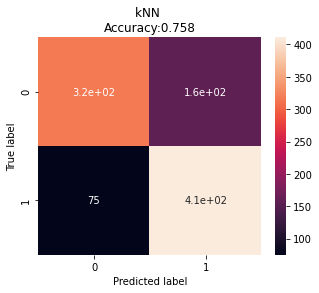

              precision    recall  f1-score   support

         0.0       0.81      0.67      0.73       474
         1.0       0.72      0.85      0.78       486

    accuracy                           0.76       960
   macro avg       0.77      0.76      0.76       960
weighted avg       0.77      0.76      0.76       960



In [75]:
best_KNR = KNeighborsRegressor(algorithm='ball_tree', leaf_size=50, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='distance')
best_KNR = best_KNR.fit(X_train, y_train)
risk_predictor = best_KNR.predict(X_test)
#print("KNN for k = ", k)
print(risk_predictor)

cm = confusion_matrix(y_test, risk_predictor) 
cm_df = pd.DataFrame(cm,
                    index = [0, 1], 
                    columns = [0, 1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('kNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, risk_predictor)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, risk_predictor))

**DecisionTreeRegressor**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [ ]:
pipe_tree = make_pipeline(DecisionTreeRegressor(random_state=1))

In [78]:
# make an array of depths to choose from 5 to 16
depths = np.arange(6, 10)
depths

array([6, 7, 8, 9])

In [79]:
#make an array of min_sample_size to choose from 10 to 25
min_samples_split = np.arange(20,26)
min_samples_split

array([20, 21, 22, 23, 24, 25])

In [ ]:
#make an array of min_samples_leaf to choose from 1 to 100
dt_num_leafs = [5, 10, 15,  20]

In [ ]:
#GridSearch to determine best parameters

param_grid = [{'DecisionTreeRegressor__max_depth':depths,
              'DecisionTreeRegressor__min_samples_split':min_samples_split,
               'DecisionTreeRegressor__min_samples_leaf':dt_num_leafs}]

In [ ]:
gs_dtr = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, n_jobs = -1, cv=5)

In [83]:
now = datetime.now()
print(now)
gs_dtr = gs_dtr.fit(X_train, y_train)
end = datetime.now()
print(end)
print(end-now)

2020-06-10 19:55:16.679420
2020-06-10 19:55:23.023672
0:00:06.344252


In [84]:
print(gs_dtr.best_score_)

0.820138888888889


In [85]:
best_params_dt = gs_dtr.best_params_
best_params_dt


{'decisiontreeclassifier__max_depth': 8,
 'decisiontreeclassifier__min_samples_leaf': 10,
 'decisiontreeclassifier__min_samples_split': 23}

[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.

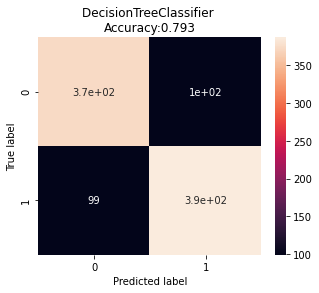

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       474
         1.0       0.79      0.80      0.80       486

    accuracy                           0.79       960
   macro avg       0.79      0.79      0.79       960
weighted avg       0.79      0.79      0.79       960



In [86]:
best_DTR = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 10, min_samples_split = 23)
best_DTR = best_DTR.fit(X_train, y_train)
risk_predictor_dt = best_DTR.predict(X_test)
#print("KNN for k = ", k)
print(risk_predictor_dt)

cm_dt = confusion_matrix(y_test, risk_predictor_dt) 
cm_df_dt = pd.DataFrame(cm_dt,
                    index = [0, 1], 
                    columns = [0, 1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df_dt, annot=True)
plt.title('DecisionTreeregressor \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, risk_predictor_dt)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, risk_predictor_dt))

**RandomForestClassifier**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestRegressor(n_estimators=10))

In [89]:
# make an array of depths to choose from 5 to 16
depths = np.arange(6, 10)
depths

array([6, 7, 8, 9])

In [90]:
#make an array of min_sample_size to choose from 10 to 25
min_samples_split = np.arange(18,22)
min_samples_split

array([18, 19, 20, 21])

In [ ]:
#make an array of min_samples_leaf to choose from 1 to 100
dt_num_leafs = [5, 7, 10]

In [ ]:
#GridSearch to determine best parameters

calibrated_param = {
    'base_estimator__max_depth': depths,
    'base_estimator__min_samples_split':min_samples_split,
    'base_estimator__min_samples_leaf':dt_num_leafs}

In [ ]:
gs_cc = GridSearchCV(calibrated_forest, calibrated_param, cv=5)

In [94]:
now = datetime.now()
print(now)
gs_cc = gs_cc.fit(X_train, y_train)
end = datetime.now()
print(end)
print(end-now)

2020-06-10 19:57:43.641268
2020-06-10 19:58:15.846946
0:00:32.205678


In [95]:
print(gs_cc.best_score_)

0.8270833333333332


In [96]:
best_params_cc = gs_cc.best_params_
best_params_cc


{'base_estimator__max_depth': 8,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 20}

[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.

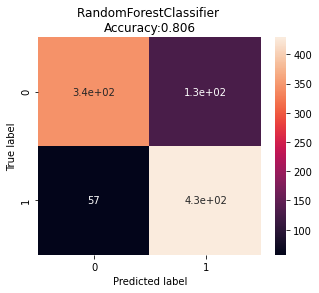

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79       474
         1.0       0.77      0.88      0.82       486

    accuracy                           0.81       960
   macro avg       0.81      0.81      0.80       960
weighted avg       0.81      0.81      0.80       960



In [97]:
best_CC = RandomForestClassifier(max_depth = 11, min_samples_leaf = 1, min_samples_split = 13)
best_CC = best_CC.fit(X_train, y_train)
risk_predictor_cc = best_CC.predict(X_test)
#print("KNN for k = ", k)
print(risk_predictor_cc)

cm_cc = confusion_matrix(y_test, risk_predictor_cc) 
cm_df_cc = pd.DataFrame(cm_cc,
                    index = [0, 1], 
                    columns = [0, 1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df_cc, annot=True)
plt.title('RandomForestClassifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, risk_predictor_cc)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, risk_predictor_cc))

**GradientBoostingRegressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


In [99]:
#GridSearch to determine best parameters
"""
gradient_boosting_parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }
"""

'\ngradient_boosting_parameters = {\n    "loss":["deviance"],\n    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],\n    "min_samples_split": np.linspace(0.1, 0.5, 12),\n    "min_samples_leaf": np.linspace(0.1, 0.5, 12),\n    "max_depth":[3,5,8],\n    "max_features":["log2","sqrt"],\n    "criterion": ["friedman_mse",  "mae"],\n    "subsample":[0.5, 0.8, 1.0],\n    "n_estimators":[10]\n    }\n'

In [ ]:
gradient_boosting_parameters = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[3,5],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 1.0],
    "n_estimators":[10]
    }

In [ ]:
gbc = GridSearchCV(GradientBoostingRegressor(), gradient_boosting_parameters, cv=10, n_jobs=-1)

In [102]:
now = datetime.now()
print(now)
gbc = gbc.fit(X_train, y_train)
end = datetime.now()
print(end)
print(end-now)

2020-06-10 19:58:40.070939
2020-06-10 19:59:58.429717
0:01:18.358778


In [103]:
print(gbc.best_score_)

0.7875


In [104]:
best_params_gbc = gbc.best_params_
best_params_gbc

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 1.0}

[1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.

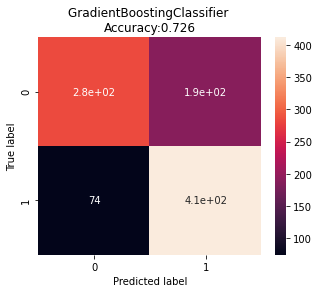

              precision    recall  f1-score   support

         0.0       0.79      0.60      0.68       474
         1.0       0.69      0.85      0.76       486

    accuracy                           0.73       960
   macro avg       0.74      0.72      0.72       960
weighted avg       0.74      0.73      0.72       960



In [105]:
best_gbc = GradientBoostingRegressor(criterion = "friedman_mse", learning_rate = 0.15,
                                      loss = "deviance", max_depth = 5, max_features = "sqrt",
                                      min_samples_leaf = 0.1, min_samples_split = 0.3545454545454546,
                                      n_estimators = 10, subsample = 1.0)#max_depth = 11, min_samples_leaf = 1, min_samples_split = 13)
best_gbc = best_gbc.fit(X_train, y_train)
risk_predictor_gbc = best_gbc.predict(X_test)
#print("KNN for k = ", k)
print(risk_predictor_gbc)

cm_gbc = confusion_matrix(y_test, risk_predictor_gbc) 
cm_df_gbc = pd.DataFrame(cm_gbc,
                    index = [0, 1], 
                    columns = [0, 1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df_gbc, annot=True)
plt.title('GradientBoostingClassifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, risk_predictor_gbc)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, risk_predictor_gbc))